# Create complete network
- get all layers created so far (grid, roads for cars and bikes, public transport layer(s)) and pre-process them until NetworkX friendly
- Add everything to at NetworkX graph 

In [1]:
import networkx as nx
import os

os.environ['USE_PYGEOS'] = '1'

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network

crs_fr = 2154 #4326 ?
plt.rcParams['figure.figsize'] = (10,10)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)


## Gather all layers (and pre-process them to make them NetworkX friendly)

### grid, boundary
- only centroids become NetworkX graph 
- have to create an attr_dict with the IRIS number and the geometry of the centroids
- need to create some index or identificator for the individual centroids within an IRIS

In [3]:
# Get boundary of GPM (for plots)

GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

In [4]:
# Get grid and centroids
grid = pd.read_csv('data/processed/IRIS_GPM.csv').rename(columns = {'geometry' : 'cells'})

# turn into geodataframe and separate centroids (for plots)
for c in ['cells', 'centroid']:
    grid[c] = grid[c].apply(shapely.wkt.loads)
    
grid = gpd.GeoDataFrame(grid, crs = crs_fr, geometry= 'cells' )
centroids = grid.set_geometry('centroid').set_crs(crs_fr)


In [5]:
## Adapted from Anastassia

# Create a unique number for each centroid
centroids = centroids.reset_index(drop = False).rename(columns = {'index' : 'id'})
centroids['nodetype'] = 'centroid'

# Create attr_dict with geometry and IRIS code
centroids["attr_dict"] = centroids.apply(lambda x: make_attr_dict(geometry = x.centroid,
                                                                  code_iris = x.CODE_IRIS,
                                                                  nodetype = x.nodetype),
                                                                  axis = 1) 

### roads DONE



In [3]:
# Get roads (car and bike)
nodes_all = pd.read_csv("./data/processed/carbike_nodes.csv")
edges_all = pd.read_csv("./data/processed/carbike_edges.csv").drop(columns = 'key')

In [4]:
### Processing: taken from Anastassia's code

# Creating the column "nodetype" 
bike_nodes = set(edges_all.loc[edges_all['edgetype'] == 'bike']['u'])

nodes_all['nodetype'] = 0

for index, row in nodes_all.iterrows():
    if row["osmid"] in bike_nodes:
        nodes_all.loc[index, "nodetype"] = 'bike'
    else:
        nodes_all.loc[index, "nodetype"] = 'car'
           
## Step 1: turn dataframes into geodataframes
# Edges 
edges_all["geometry"] = edges_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_all = gpd.GeoDataFrame(edges_all, geometry = "geometry") 

# Nodes
nodes_all["geometry"] = nodes_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_all = gpd.GeoDataFrame(nodes_all, geometry = "geometry")

## Step 2: Sort values and drop duplicates 
nodes_all = nodes_all.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
nodes_all["attr_dict"] = nodes_all.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  nodetype = x.nodetype),
                                                                  axis = 1) 

# add edge ids (strings with "id1, id2" sorted (id1 < id2))
edges_all["edge_id"] = edges_all.apply(lambda x: str(sorted([x["u"], x["v"]])), axis = 1)
# (edge ids are set as strings; converting back: with "from ast import literal_eval" fct)
# finding duplicates by ["osmid", "oneway", "edge_id", "length"]
# simplifying network into undirected - beu and ceu contain the "undirected" edges
# (removing all parallel edges)

# MOD: removed oneway and length from the subset
edges_all_unique = edges_all.drop_duplicates(subset = ["osmid", "edge_id"],
                  keep = "first",
                  inplace = False,
                  ignore_index = True).copy()

# remove duplicates
edges_all_unique = edges_all_unique.drop_duplicates(subset = ["u", "v", "osmid", "edge_id", "edgetype"], 
                          keep = "first",
                          ignore_index = True, 
                          inplace = False)

edges_all_unique_tokeep = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"]=="bike")].index
edges_all_unique_todrop = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"] == "car")].index

# MOD changed "multi" to "both"
edges_all_unique.loc[edges_all_unique_tokeep, "edgetype"] = "both"
edges_all_unique = edges_all_unique.drop(edges_all_unique_todrop)

# add attribute dictionary (for nx)
edges_all_unique["attr_dict"] = edges_all_unique.apply(lambda x: make_attr_dict(edgetype = x.edgetype,
                                                    edge_id = x.edge_id,
                                                    # MOD-Stephan: used to be coord
                                                    geometry = x.geometry,
                                                    intnodes = []), # intnodes attribute: for storing simplification info on interstitial nodes 
                             axis = 1)

# sort by "left" node (id1 < id2 - to control order of tuple keys in nx)
edges_all_unique["order"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.sort_values(by = "order").reset_index(drop = True)
# MOD: used "x" and "y" insteads of "orgig" and "dest"
edges_all_unique["x"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique["y"] = edges_all_unique.apply(lambda x: np.max([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.drop(columns = ["order", "u", "v"]) # instead of "u" and "v",
# we will use "origin" and "destination" where osmid(origin) < osmid (destination)!

del(edges_all_unique_todrop, edges_all_unique_tokeep)  

In [8]:
# # Plot
# ax = plt.axes()
# edges_all.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_all.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

# Connect centroids and roads

## on less than all IRIS

In [80]:
# subset data
cells_1IRIS = grid.head(160).reset_index(drop = True)
centroids_1IRIS = centroids.loc[centroids['CODE_IRIS'].isin(cells_1IRIS['CODE_IRIS'])].reset_index(drop = True)
edges_all_unique_1 = edges_all_unique.set_crs(4326).to_crs(2154)
roads_1IRIS = gpd.sjoin(edges_all_unique_1, cells_1IRIS, how='inner', predicate='intersects').reset_index(drop = True)

In [81]:
# # plot
# ax = plt.axes()
# cells_1IRIS.plot(ax=ax, alpha = 0.5)
# centroids_1IRIS.plot(ax=ax, markersize = 7)
# roads_1IRIS.plot(ax=ax, cmap = 'pink')

In [82]:
# pre=process for snkit
from shapely.validation import make_valid

centroids_1IRIS = centroids_1IRIS.rename(columns={'centroid' : 'geometry'})

nodes = gpd.GeoDataFrame(centroids_1IRIS['geometry'], geometry = 'geometry')
nodes.geometry = nodes.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

edges = gpd.GeoDataFrame(roads_1IRIS['geometry'], geometry = 'geometry')
edges.geometry = edges.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)


def plot_network(n):
    df = pd.concat([n.nodes, n.edges], axis=0, sort=False)
    df = gpd.GeoDataFrame(df, crs = crs_fr)
    df.plot(linewidth = 0.5, markersize = 1, )

<Axes: >

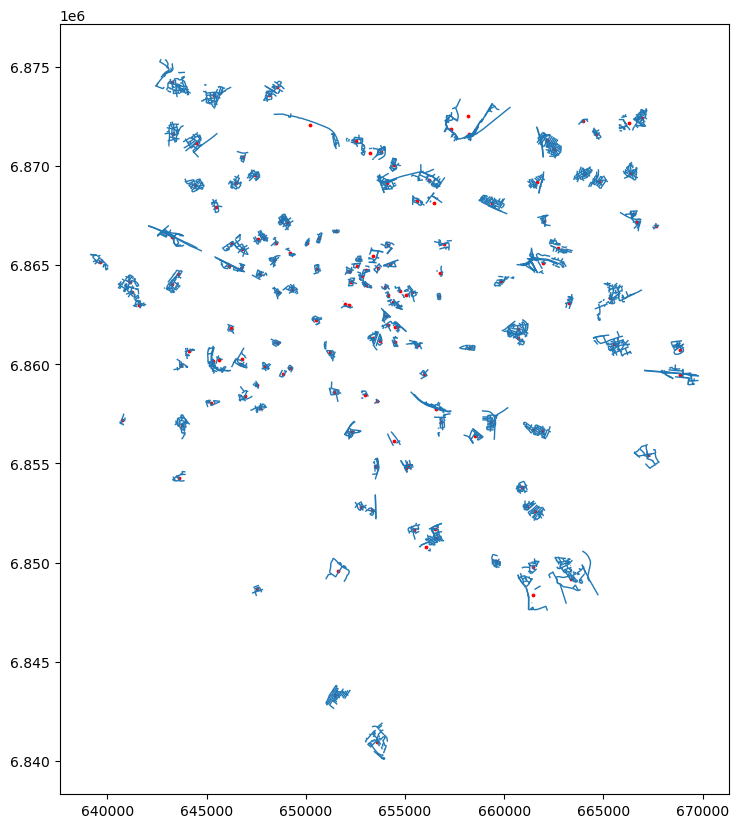

In [83]:
# create the network based on my current nodes/edges

base_network = snkit.Network(nodes, edges)


#plot
ax = plt.axes()
base_network.edges.plot(ax=ax, linewidth = 1)
base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [84]:
# link centroids to their nearest edge

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?

# plot
ax = plt.axes()
linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)


/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as RGF93 v1 / Lambert-93 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as RGF93 v1 / Lambert-93 (the single non-null crs provided).
  warnings.warn(


GEOSException: TopologyException: side location conflict at 653091.9567589286 6863966.7555403514. This can occur if the input geometry is invalid.

## for all IRIS

<Axes: >

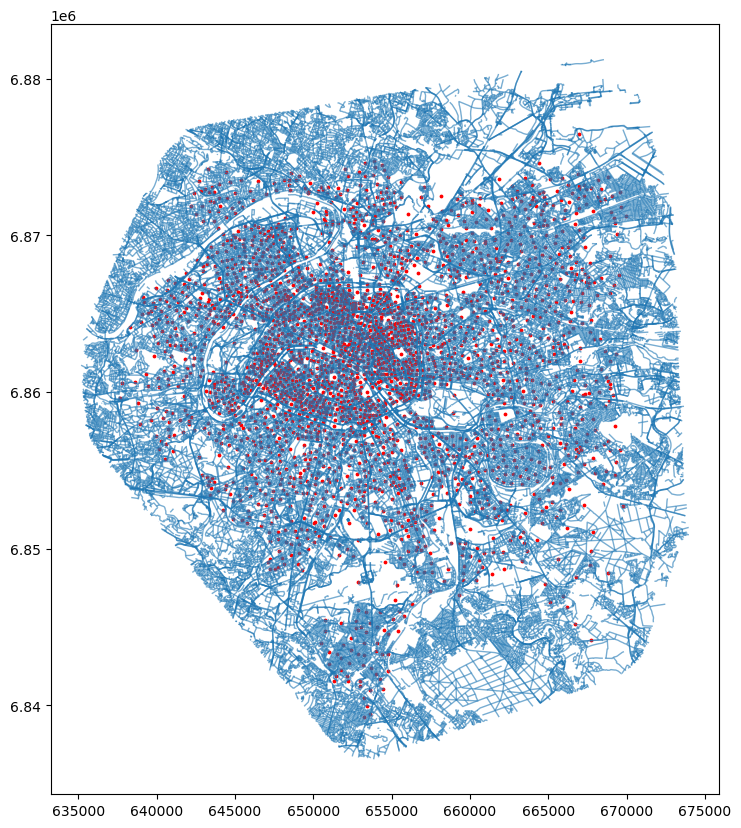

In [9]:
# create the network based on current nodes/edges

nodes = centroids.rename(columns = {'centroid' : 'geometry'}).set_geometry('geometry').set_crs(crs_fr)
edges = gpd.GeoDataFrame(edges_all_unique, geometry = 'geometry', crs = 4326).to_crs(crs_fr)
base_network = snkit.Network(nodes, edges)

#plot
ax = plt.axes()
base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)


In [ ]:
# link centroids to their nearest edge

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?

# # # plot
# # ax = plt.axes()
# # linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# # linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)
# plot_network(linked)

#653091.9567589286



NEXT STEPS:
- adding edges from centroids to their nearest carbike edge has divided the original carbike edge into two, so I need to use the new network instead of the old one (at least edges-wise)
- adding edges from centroids to their nearest carbike edge has created new nodes (intersections) which need to be added to the old node network instead of being added to the centroid grid (unless I use those new nodes as a replacement for the centroids? It would only be a problem for cells that don't have edges -because then the centroid gets mvoed to a neighboring cell at best, one further away at worst). 

# Old code, wouldn't delete yet 

In [ ]:
# # Create NetworkX graph of the roads (Anastassia code)

# # CREATE NX OBJECTS
# # make multinetwork containing ALL edges
# car_bike_graph = nx.Graph()
# car_bike_graph.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

# # MOD: x and y instead of orig and dest
# car_bike_graph.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# # MOD: removed the LCC part

In [ ]:
# # Create NetworkX graph of the centroids

# centroid_graph = nx.Graph()
# centroid_graph.add_nodes_from(centroids.loc[:,["id", "attr_dict"]].itertuples(index = False))


In [ ]:
# # Bringing everything together attempt 1

# # test: have everything in one graph
# all_layers = nx.Graph()

# # Add centroids to the carbike network 
# all_layers.add_nodes_from(centroids.loc[:,["id", "attr_dict"]].itertuples(index = False))
# all_layers.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
# all_layers.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# # subset: centroid nodes in the graph
# centroids_in_carbike_graph = [n for n,v in all_layers.nodes(data=True) if v['nodetype'] == 'centroid']
# # subset: carbike nodes in the graph
# carbike_nodes_from_carbike_graph = [n for n,v in all_layers.nodes(data=True) if v['nodetype'] != 'centroid']
# # subset: carbike edges in the graph
# carbike_edges_from_carbike_graph = all_layers.edges

# # PROBLEM: how do I find the nearest carbike node to a centroid node???

# #nx.ego_graph(car_bike_graph, centroids_in_carbike_graph, radius=1, center=True, undirected=False, distance=None)

In [ ]:
# # Plot all on top of each other (useless)
# ax = plt.axes()
# grid.plot(ax=ax, markersize = 0.1, facecolor = 'green', alpha = 0.5)
# edges_all_unique.plot(ax=ax, linewidth = 0.5, alpha = 0.5)
# nodes_all.plot(ax=ax, markersize = 0.1, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', alpha = 1)


# rouwette et al., 2016
# three activites in participatory modeling:
# divergent activites:
# producing different ideas and interpretations
# conergent activities
# clustering ideas and interpretations in a dyniamic structure
# evaluative activities
# choosing between options to address the problem

# (hovmand et al., 2018)

# r5py

In [24]:
import geopandas
import datetime
from r5py import TravelTimeMatrixComputer, TransitMode, LegMode
from r5py import TransportNetwork

points = nodes_all.head(50).rename(columns = {'osmid':'id'})
points.head()

origin = points.head(1).rename(columns = {'osmid':'id'})
origin

,id,y,x,geometry,nodetype,attr_dict
0,122926,48.884082,2.463549,POINT (2.46355 48.88408),car,"{'lat': 2.4635493, 'lon': 48.8840815, 'nodetyp..."


In [34]:
transport_network = TransportNetwork("./data/test.osm.pbf")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "TransportNetwork.java", line 131, in com.conveyal.r5.transit.TransportNetwork.fromFiles
Exception: Java Exception

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_39777/4051408204.py", line 1, in <module>
    transport_network = TransportNetwork("./data/test.osm.pbf")
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/r5py/r5/transport_network.py", line 48, in __init__
    self._transport_network = com.conveyal.r5.transit.TransportNetwork.fromFiles(
java.lang.java.lang.ArrayIndexOutOfBoundsException: java.lang.ArrayIndexOutOfBoundsException: Attempt to seek beyond end of edge store

During handling of the a

In [26]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=origin,
    destinations=points
)

travel_time_matrix = travel_time_matrix_computer.compute_travel_times()
travel_time_matrix.head()

,from_id,to_id,travel_time
0,122926,122926,1.0
1,122926,122935,37.0
2,122926,122946,93.0
3,122926,122954,NaN
4,122926,122976,NaN


# get pbf file

In [38]:
import osmnx as ox

nodes_all = nodes_all.set_crs('EPSG:4326')
# make multinetwork containing ALL edges and ndoes
G = nx.Graph()

#MOD rename x and y into lat and lon (don't even know if it's accurate)
G.add_nodes_from(nodes_all.loc[:,["osmid", 'attr_dict']].itertuples(index = False)) #OLD: 'attr_dict'

# MOD: x and y instead of orig and dest
G.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

G.graph['crs'] = 'EPSG:4326'

In [39]:
ox.settings.all_oneway = True
ox.settings.log_console = True

#G3 = ox.graph_from_place("Delft, the Netherlands", network_type = 'drive')

#ox.save_graph_xml(G, filepath = 'test.xml')

nx.write_gml(G, 'testGML.gml')

NetworkXError: <LINESTRING (2.464 48.884, 2.462 48.884, 2.462 48.884, 2.462 48.884, 2.461 4...> is not a string

In [24]:
!osmium cat test.osm -o test1.osm.pbf 

[======================================================================] 100% 


In [26]:
!osmosis --read-xml file="test.osm" --write-pbf file="test.osm.pbf"

Apr 04, 2023 2:10:19 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.48.3
Apr 04, 2023 2:10:19 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Apr 04, 2023 2:10:19 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Launching pipeline execution.
Apr 04, 2023 2:10:19 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline executing, waiting for completion.
Apr 04, 2023 2:10:21 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline complete.
Apr 04, 2023 2:10:21 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Total execution time: 2047 milliseconds.
